# Assignment 11
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### In this assignment we are going to use our assignment 6 and on top of that we are going to implement the below functionalities:
* Add CutOut to this
* Use LR Finder to find the best starting learning rate
* Use SDG with Momentum
* Train for 100 Epochs
* Keep Verbose = 0 (no logs)
* Pring the top accuracy
* Show Training and Test Accuracy curves
* Run GradCAM on the any 25 misclassified images

### So to achieve this goal lets first import keras library and  import all pakages and functions from keras with which we are going to build the CNN model

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
import cv2

### Now we are going to load the pre-shuffled CIFAR10 data from keras. Out of total 60k data we have 50k different class image as train data and 10k image as test data which is autometically predefined in mnist dataset. So here we have total 10 different classes of images as: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck.

In [18]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))
print (num_classes)
print (num_train)
print (train_features.shape)

10
50000
(50000, 32, 32, 3)


### Now let's look into some images. Here we are going to pick one image from each class randomly to see how it looks:

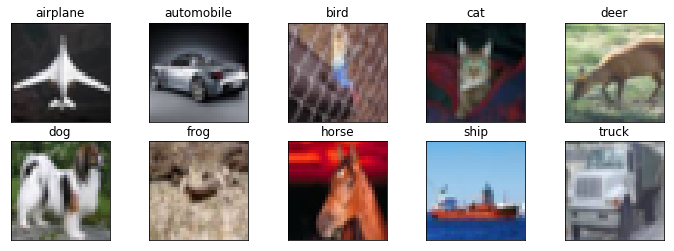

In [19]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(12,4))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

### Now here we are going to create a function which is going to plot our train and test model accuracy and losses with respect to epochs.

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

### Also, here we have created one more function which is going to give us actual  test accuracy from model and test data:

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

### Now, lets scale the test and train data and change labels from 1-dimentional class matrix to 10 dimentional class matrix so that we can predict out of 10 class.

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

### Now let's implement the below techniques and create our model:
* Using Image Normalization
* Making use of Batch Normalization
* Making use of L2 Regularizer


In [37]:
# Define the model
model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Convolution2D(32, 1, 1))


model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Convolution2D(32, 1, 1))


model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Convolution2D(10, 1, 1))

model.add(AveragePooling2D(pool_size = (4,4)))
model.add(Flatten())


model.add(Activation('softmax'))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regularizer=<keras.reg..., padding="same"

### Now let's look at the model summary, Here we can see we have total of 455K parameters to train. Now let's see how this model is going to perform:

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_15 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_16 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 64)        0         
__________

### As we have created our model now let's find out best learning rate to start our training, for that purpose we have defined the below LRFinder class:

In [0]:
from matplotlib import pyplot as plt
import math
from keras.callbacks import LambdaCallback
import keras.backend as K
import numpy as np


class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """
    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if batch > 5 and (math.isnan(loss) or loss > self.best_loss * 4):
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1):
        num_batches = epochs * x_train.shape[0] / batch_size
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(num_batches))

        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                        batch_size=batch_size, epochs=epochs,
                        callbacks=[callback])

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def find_generator(self, generator, start_lr, end_lr, epochs=1, steps_per_epoch=None, **kw_fit):
            if steps_per_epoch is None:
                try:
                    steps_per_epoch = len(generator)
                except (ValueError, NotImplementedError) as e:
                    raise e('`steps_per_epoch=None` is only valid for a'
                            ' generator based on the '
                            '`keras.utils.Sequence`'
                            ' class. Please specify `steps_per_epoch` '
                            'or use the `keras.utils.Sequence` class.')
            self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(steps_per_epoch))

            # Save weights into a file
            self.model.save_weights('tmp.h5')

            # Remember the original learning rate
            original_lr = K.get_value(self.model.optimizer.lr)

            # Set the initial learning rate
            K.set_value(self.model.optimizer.lr, start_lr)

            callback = LambdaCallback(on_batch_end=lambda batch,
                                      logs: self.on_batch_end(batch, logs))

            self.model.fit_generator(generator=generator,
                                     epochs=epochs,
                                     steps_per_epoch=steps_per_epoch,
                                     callbacks=[callback],
                                     **kw_fit)

            # Restore the weights to the state before model fitting
            self.model.load_weights('tmp.h5')

            # Restore the original learning rate
            K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale('log')

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        derivatives = self.get_derivatives(sma)[n_skip_beginning:-n_skip_end]
        lrs = self.lrs[n_skip_beginning:-n_skip_end]
        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(lrs, derivatives)
        plt.xscale('log')
        plt.ylim(y_lim)

    def get_derivatives(self, sma):
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivatives.append((self.losses[i] - self.losses[i - sma]) / sma)
        return derivatives

    def get_best_lr(self, sma, n_skip_beginning=10, n_skip_end=5):
        derivatives = self.get_derivatives(sma)
        best_der_idx = np.argmax(derivatives[n_skip_beginning:-n_skip_end])[0]
        return self.lrs[n_skip_beginning:-n_skip_end][best_der_idx]

### Now let's run the model for 10 epochs to find the best learning Rate:

In [26]:
model1 = model
model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

lr_finder = LRFinder(model1)
lr_finder.find(train_features, train_labels, 0.0001, 1, 256, 10)

Epoch 1/10
50000/50000 [==============================] - 16s 315us/step - loss: 0.3049 - acc: 0.9033
Epoch 2/10
50000/50000 [==============================] - 11s 217us/step - loss: 0.2422 - acc: 0.9199
Epoch 3/10
50000/50000 [==============================] - 11s 218us/step - loss: 0.2107 - acc: 0.9319
Epoch 4/10
50000/50000 [==============================] - 11s 216us/step - loss: 0.1899 - acc: 0.9397
Epoch 5/10
50000/50000 [==============================] - 11s 214us/step - loss: 0.1860 - acc: 0.9435
Epoch 6/10
50000/50000 [==============================] - 11s 213us/step - loss: 0.2145 - acc: 0.9423
Epoch 7/10
50000/50000 [==============================] - 11s 212us/step - loss: 0.2650 - acc: 0.9345
Epoch 8/10
50000/50000 [==============================] - 11s 212us/step - loss: 0.3221 - acc: 0.9200
Epoch 9/10
19712/50000 [==========>...................] - ETA: 6s - loss: 0.3899 - acc: 0.9029

### In the below we are going to plot learning rate vs loss curve to findout best initial learning rate:

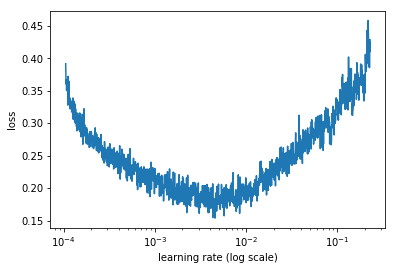

In [27]:
lr_finder.plot_loss()

### So, from the above we can see that loss is minimum in between 0.01-0.001 and it is minimum at 0.004 which we are going to take as our initial learning rate.
### Now, lets implement cutout augmentation technique in our CFIAR10 dataset and train the model with augmented data:

In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

### Now we are going to run this model for 100 epochs and let's check what training accuracy we are going to get:

In [0]:
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint

def scheduler(epoch, lr):
  return round(0.004 * 1/(1 + 0.319 * epoch), 10)

# Initial learning rate got from learning rate finder
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.004, momentum=0.9, nesterov=False), metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_s

Model took 1151.02 seconds to train


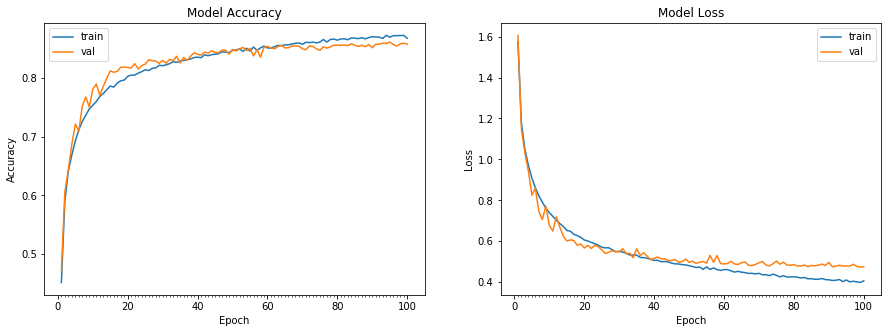

Best Accuracy on test data is: 86.11


In [39]:
# checkpoint
filepath="best_model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

from keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(zoom_range=0.0,horizontal_flip=False,
                             featurewise_center=True, featurewise_std_normalization=True,preprocessing_function=get_random_eraser(v_l=0, v_h=1,pixel_level=True))

datagen_test = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
iterator_test = datagen_test.flow(test_features, test_labels, batch_size=len(test_features), shuffle=False)
test_features_2, test_labels_2 = iterator_test.next()

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen_train.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features_2, test_labels_2), verbose=0,
                                 callbacks=[checkpoint, LearningRateScheduler(scheduler, verbose=0)])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
model.load_weights('best_model.hdf5')
print ("Best Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

### So, from the above we can see that best model validation accuracy is 86.11. Now lets try to find the some misclassified image on top of which we would like to apply gradCAM technique.

In [0]:
# getting index of all misclasified images
y_pred = model.predict(test_features)
img_index = []
for i in range(1,test_features.shape[0]):
  if np.argmax(y_pred[i])!=np.argmax(test_labels[i]):
    img_index.append(i)

### Now let's create some function for gradCAM

In [0]:
def image_reconstract(x):
  # normalize tensor: center on 0., ensure std is 0.1
  x -= x.mean()
  x /= (x.std() + 1e-5)
  x *= 0.1

  # clip to [0, 1]
  x += 0.5
  x = np.clip(x, 0, 1)

  # convert to RGB array
  x *= 255
  #x = x.transpose((1, 2, 0))
  x = np.clip(x, 0, 255).astype('uint8')
  return x

  
def applygradCAM(image):
  # expanding dimension for prediction
  x = np.expand_dims(image, axis=0)
  
  # prediction of the image
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  
  # Getting the output of the last convolutional layer 
  last_conv_layer = model.get_layer("conv2d_35")
  
  # Claculating the gradients
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(256):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
  # Creating the heatmap
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap) 
  
  # Resize heatmap to original image size
  heatmap = cv2.resize(heatmap, (x.shape[1], x.shape[2]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  
  # Creating the superimposed Image
  superimposed_img = cv2.addWeighted(image_reconstract(image), 0.6, heatmap, 0.4, 0)
  return superimposed_img  

### Now lets apply gradCAM on top of misclassified image:

In [45]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(12,4))

img_actual = [] 
img_gradCam = [] 
img_actual_value = []
img_pred_value = []
for i in range(1,26):
    img_req = np.array(test_features[img_index[i-1]]).astype(np.float64)
    img_req = image_reconstract(img_req)
    img_actual.append(img_req)
    img_req_grad = applygradCAM(test_features[img_index[i-1]])
    img_gradCam.append(img_req_grad)
    img_actual_value.append(class_names[np.argmax(test_labels[img_index[i-1]])])
    img_pred_value.append(class_names[np.argmax(y_pred[img_index[i-1]])])
      

<Figure size 864x288 with 0 Axes>

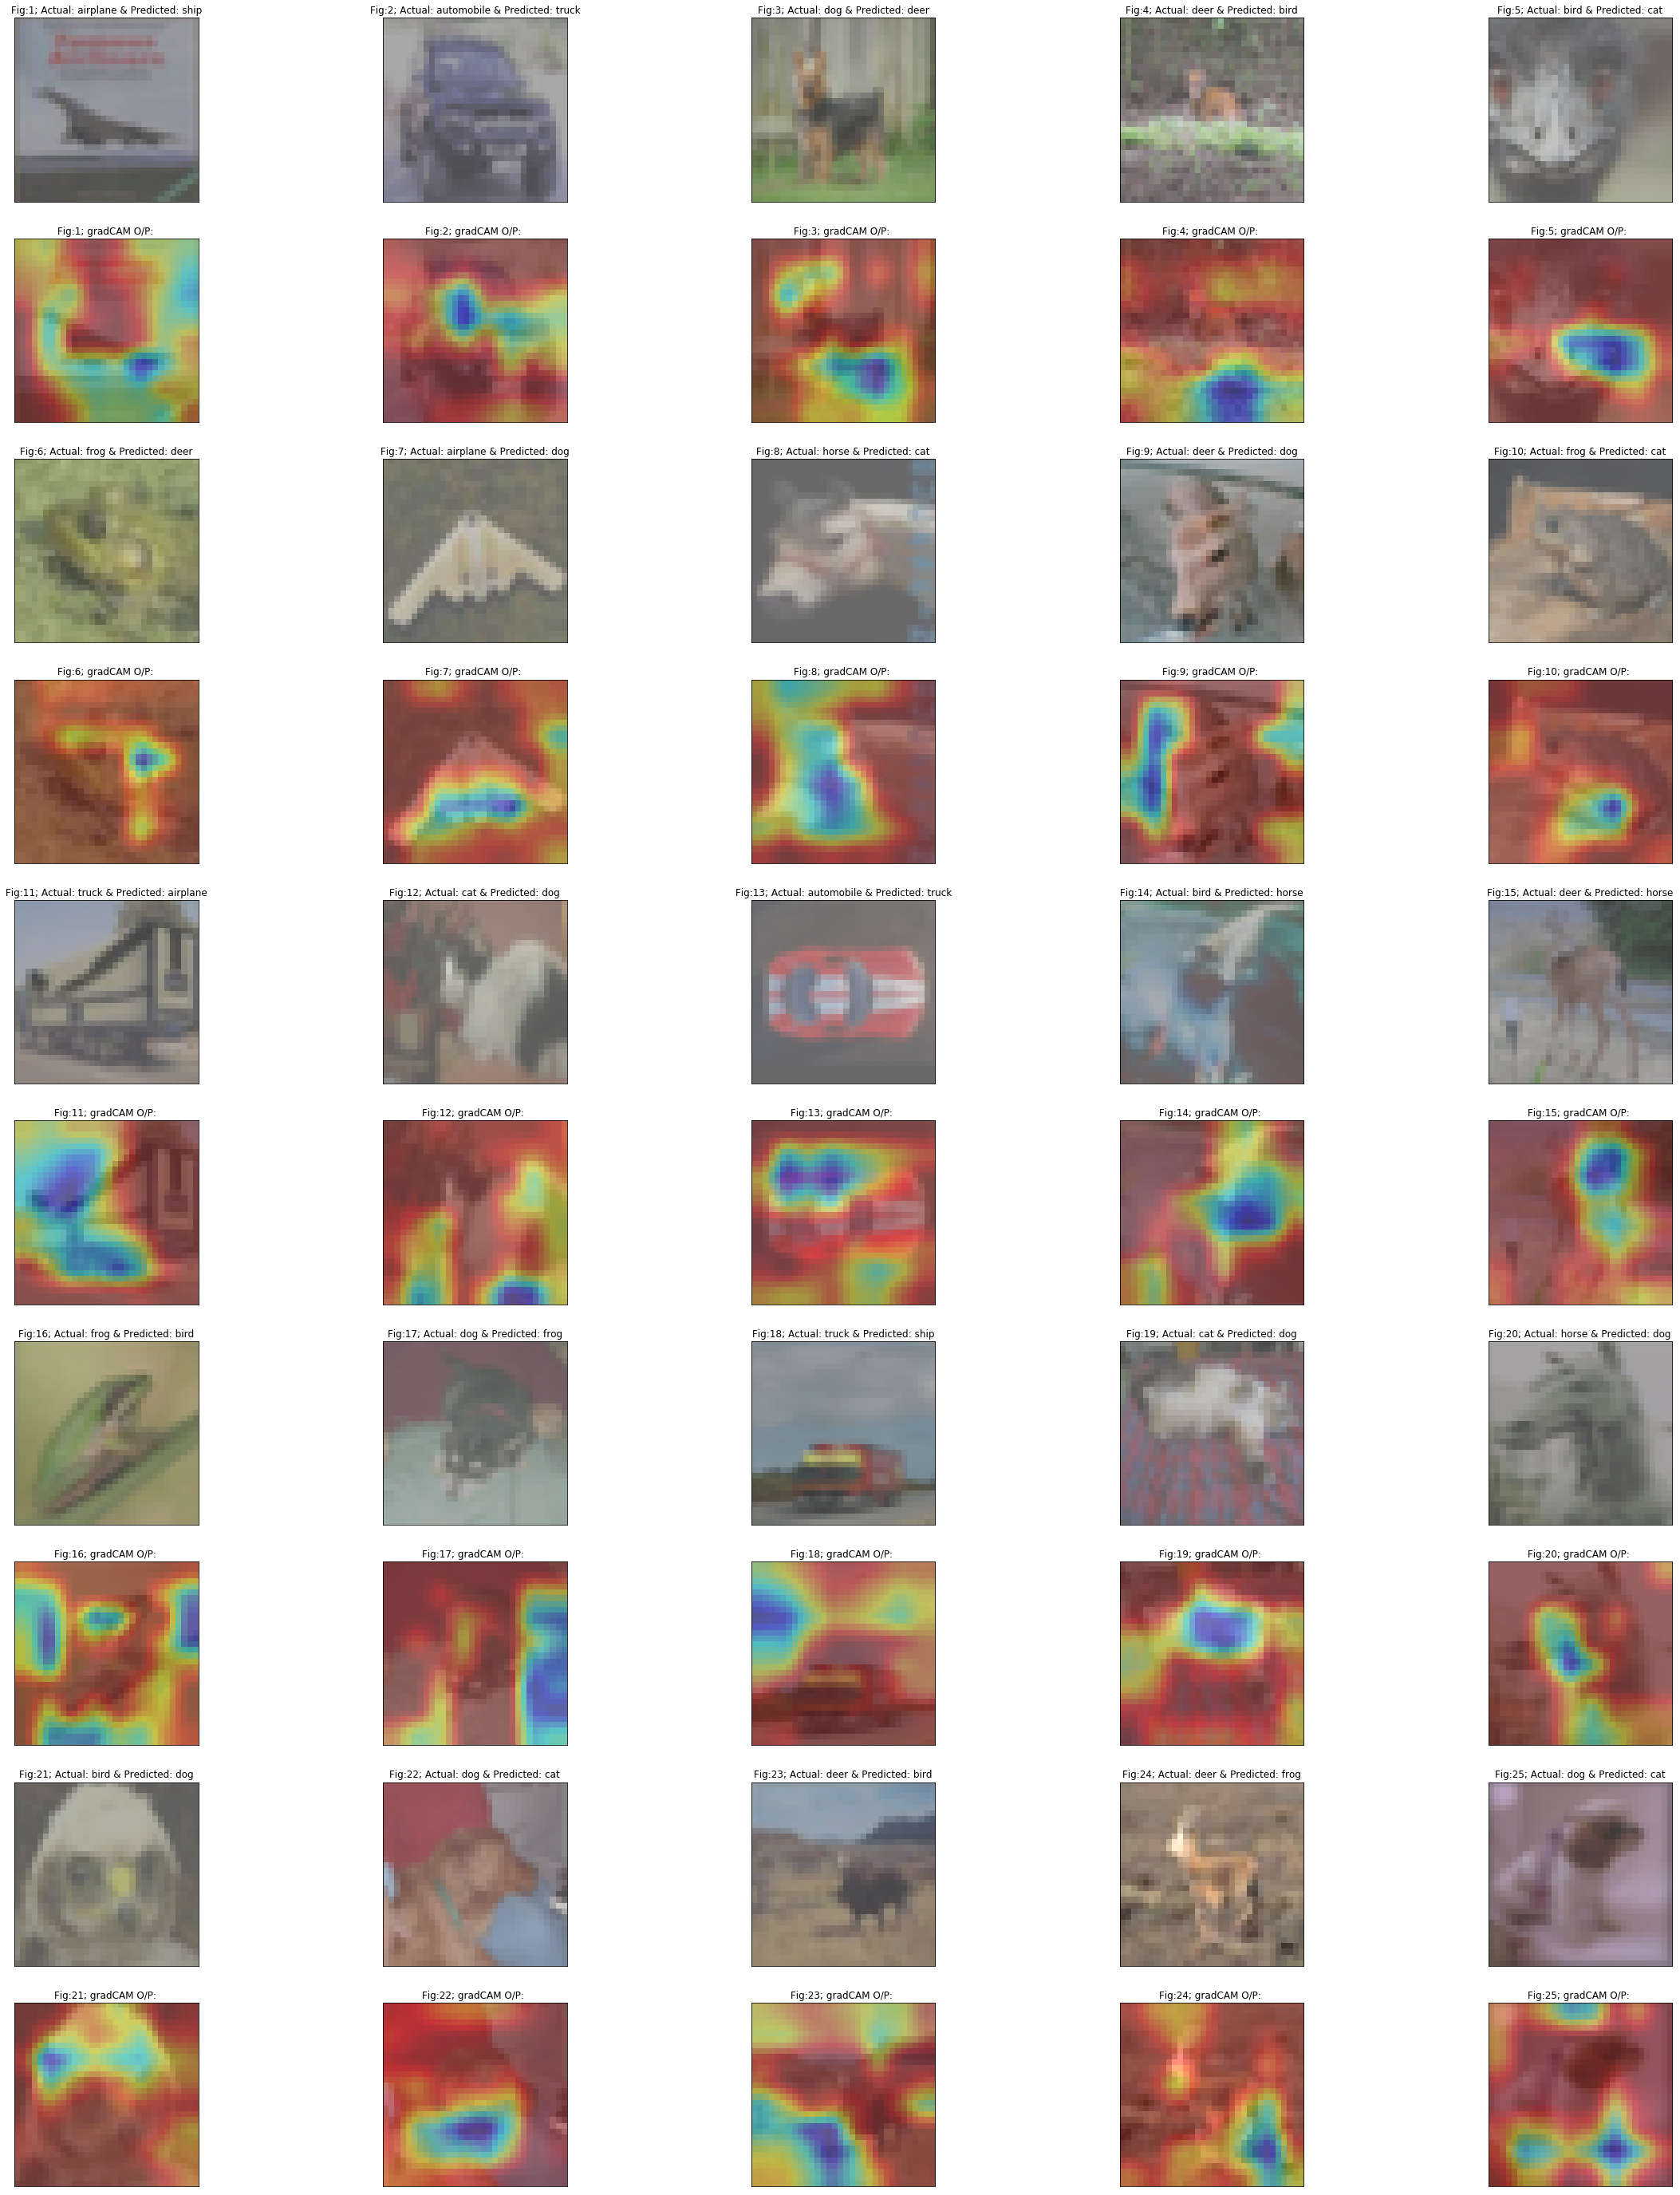

In [48]:
row = 10
col = 5
fig=plt.figure(figsize=(40,50))
j=0
for i in range(0,25):
  if i%5==0 and i!=0:
    j=2*i
  fig.add_subplot(row,col,j+1)
  plt.imshow(img_actual[i]) 
  plt.title('Fig:'+ str(i+1) +'; Actual: '+str(img_actual_value[i])+' & Predicted: '+str(img_pred_value[i]))
  plt.xticks([])
  plt.yticks([])
  fig.add_subplot(row,col,j+6)
  plt.imshow(img_gradCam[i])  
  plt.title('Fig:'+ str(i+1) +'; gradCAM O/P: ')
  plt.xticks([])
  plt.yticks([])
  j+=1
plt.show() 

### In the above we can see 25 missclassified actual images and their GRADCam output in below section.